In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from copy import deepcopy
import tensorflow as tf
from sklearn.datasets import load_digits

/Users/takahashihideyuki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/takahashihideyuki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/takahashihideyuki/.pyenv/versions/anaconda3-2019.10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([

# 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。


フォワードプロパゲーションの数式は以下のようになります。

$$
a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}
$$

𝑎𝑖,𝑗,𝑚 : 出力される配列のi行j列、mチャンネルの値


𝑖 : 配列の行方向のインデックス


𝑗 : 配列の列方向のインデックス


𝑚 : 出力チャンネルのインデックス


𝐾 : 入力チャンネル数


𝐹ℎ,𝐹𝑤 : 高さ方向（h）と幅方向（w）のフィルタのサイズ


𝑥(𝑖+𝑠),(𝑗+𝑡),𝑘 : 入力の配列の(i+s)行(j+t)列、kチャンネルの値


𝑤𝑠,𝑡,𝑘,𝑚 : 重みの配列のs行t列目。kチャンネルの入力に対して、mチャンネルへ出力する重み


𝑏𝑚 : mチャンネルへの出力のバイアス項


全てスカラーです。


次に更新式です。1次元畳み込み層や全結合層と同じ形です。

$$
w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}} \\
b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}
$$

𝛼 : 学習率


∂𝐿∂𝑤𝑠,𝑡,𝑘,𝑚 : 𝑤𝑠,𝑡,𝑘,𝑚 に関する損失 𝐿 の勾配


∂𝐿∂𝑏𝑚 : 𝑏𝑚 に関する損失 𝐿 の勾配


勾配 ∂𝐿∂𝑤𝑠,𝑡,𝑘,𝑚 や ∂𝐿∂𝑏𝑚 を求めるためのバックプロパゲーションの数式が以下である。


∂𝐿∂𝑤𝑠,𝑡,𝑘,𝑚=∑𝑖=0𝑁𝑜𝑢𝑡,ℎ−1∑𝑗=0𝑁𝑜𝑢𝑡,𝑤−1∂𝐿∂𝑎𝑖,𝑗,𝑚𝑥(𝑖+𝑠)(𝑗+𝑡),𝑘∂𝐿∂𝑏𝑚=∑𝑖=0𝑁𝑜𝑢𝑡,ℎ−1∑𝑗=0𝑁𝑜𝑢𝑡,𝑤−1∂𝐿∂𝑎𝑖,𝑗,𝑚

∂𝐿∂𝑎𝑖 : 勾配の配列のi行j列、mチャンネルの値


𝑁𝑜𝑢𝑡,ℎ,𝑁𝑜𝑢𝑡,𝑤 : 高さ方向（h）と幅方向（w）の出力のサイズ


前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}\\
\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}
$$

∂𝐿∂𝑥𝑖,𝑗,𝑘 : 前の層に流す誤差の配列のi列j行、kチャンネルの値


𝑀 : 出力チャンネル数


ただし、 𝑖−𝑠<0 または 𝑖−𝑠>𝑁𝑜𝑢𝑡,ℎ−1 または 𝑗−𝑡<0 または 𝑗−𝑡>𝑁𝑜𝑢𝑡,𝑤−1 のとき ∂𝐿∂𝑎(𝑖−𝑠),(𝑗−𝑡),𝑚=0 です。

In [2]:
class CNN2d:
    def __init__(self, n_in_ch, n_filter, filter_h, filter_w, initializer, optimizer, layer):
        self.n_in_ch = n_in_ch
        self.B = initializer.B(n_filter)
        self.W = initializer.W(n_in_ch, n_filter, filter_h, filter_w) 
        '''
        self.W:
        出力のshapeは(n_out_ch, n_in_ch, filter_h, filter_w)　
        全結合層に合わせる為、引数はinとoutが逆転
        '''
        self.n_filter = n_filter
        self.HB = 0
        self.HW = 0
        self.optimizer = optimizer
        self.layer = layer

    
    def forward(self, X):
        """
        X : 次の形のndarray, shape (batch_size, n_in_ch, n_in_h, n_in_w)
        
        W : 次の形のndarray, shape (n_out_ch, n_in_ch, filter_h, filter_w) #n_out_ch = n_filter
        
        """
        self.X = X
        
        batch_size, n_in_ch, n_in_h, n_in_w = X.shape
        n_out_ch, n_in_ch, filter_h, filter_w = self.W.shape
        
        n_out_h, n_out_w = self.layer.calc_out_shape(n_in_h, n_in_w, filter_h, filter_w, self.layer.n_pad, self.layer.stride)
        
        col = np.zeros([n_out_h * n_out_w * batch_size, n_in_ch * filter_h * filter_w])
        
        self.n_out_h = n_out_h
        self.n_out_w = n_out_w        
        
        #パディングの実装　（ゼロパディング処理）
        X_pad = np.pad(X, [(0,0), (0,0), (self.layer.n_pad, self.layer.n_pad), (self.layer.n_pad, self.layer.n_pad)], 'constant', constant_values=0)

        #im2col処理（DIC式）
        for n in range(batch_size):
            for i in range(n_out_h):
                for j in range(n_out_w): 
                    patch = X_pad[n, : , i * self.layer.stride : i * self.layer.stride + filter_h, 
                                               j * self.layer.stride : j * self.layer.stride + filter_w]

                    col[n * n_out_h *n_out_w + i * n_out_w + j, : ] = np.reshape(patch, -1)
        
        self.col = col
        self.col_W = self.W.reshape(self.n_filter, -1).T
        
        out = self.col @ self.col_W + self.B
            
        A = out.reshape(batch_size, n_out_h, n_out_w, -1).transpose(0, 3, 1, 2)
   
        return A
    
    
    def backward(self, dA):
        #col2im処理（魚本式）
        
        n_out_ch, n_in_ch, filter_h, filter_w = self.W.shape
        dA = dA.transpose(0,2,3,1).reshape(-1, n_out_ch)

        dB = np.sum(dA, axis=0) / self.layer.batch_size
        dW = self.col.T @ dA
        dW = dW.transpose(1, 0).reshape(n_out_ch, n_in_ch, filter_h, filter_w) / self.layer.batch_size

        dcol = dA @ self.col_W.T
        
        batch_size, n_in_ch, n_in_h, n_in_w = self.X.shape
        
        dcol = dcol.reshape(batch_size, self.n_out_h, self.n_out_w, n_in_ch, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
        
        img = np.zeros((batch_size, n_in_ch, n_in_h + 2*self.layer.n_pad + self.layer.stride - 1, n_in_w + 2*self.layer.n_pad + self.layer.stride - 1))
        for y in range(filter_h):
            y_max = y + self.layer.stride * self.n_out_h
            for x in range(filter_w):
                x_max = x + self.layer.stride * self.n_out_w
                img[:, :, y:y_max:self.layer.stride, x:x_max:self.layer.stride] += dcol[:, :, y, x, :, :]

        dX=  img[:, :, self.layer.n_pad : n_in_h + self.layer.n_pad, self.layer.n_pad : n_in_w + self.layer.n_pad]
        
        
        self.dB = dB
        self.dW = dW
        
        
        # 更新
        if self.layer.optimizer == "SGD":
            self.B, self.W = self.optimizer.update(self)
        elif self.layer.optimizer == "AdaGrad":
            self.B, self.W, self.HB, self.HW = self.optimizer.update(self)

        return dX

# 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

$$
N_{h,out} =  \frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}} + 1\\
N_{w,out} =  \frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}} + 1
$$

𝑁𝑜𝑢𝑡 : 出力のサイズ（特徴量の数）


𝑁𝑖𝑛 : 入力のサイズ（特徴量の数）


𝑃 : ある方向へのパディングの数


𝐹 : フィルタのサイズ


𝑆 : ストライドのサイズ


ℎ が高さ方向、 𝑤 が幅方向である

In [3]:
def calc_out_shape(self, n_in_h, n_in_w, fillter_h, fillter_w, n_pad, stride):
    n_out_h = int((n_in_h + 2*n_pad - fillter_h) / stride + 1)
    
    n_out_w = int((n_in_w + 2*n_pad - fillter_w) / stride + 1)
    
    return n_out_h, n_out_w

# 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

$$
a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}
$$

𝑃𝑖,𝑗 : i行j列への出力する場合の入力配列のインデックスの集合。 𝑆ℎ×𝑆𝑤 の範囲内の行（p）と列（q）


𝑆ℎ,𝑆𝑤 : 高さ方向（h）と幅方向（w）のストライドのサイズ


(𝑝,𝑞)∈𝑃𝑖,𝑗 : 𝑃𝑖,𝑗 に含まれる行（p）と列（q）のインデックス


𝑎𝑖,𝑗,𝑚 : 出力される配列のi行j列、kチャンネルの値


𝑥𝑝,𝑞,𝑘 : 入力の配列のp行q列、kチャンネルの値


ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになります。


バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス (𝑝,𝑞) を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [5]:
class MaxPool2D:
    def __init__(self, pool_h, pool_w, pool_stride, pool_pad, layer):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.pool_stride = pool_stride
        self.pool_pad = pool_pad
        self.layer = layer
    
    def forward(self, X):
        
        batch_size, n_in_ch, n_in_h, n_in_w = X.shape
        n_out_h, n_out_w = self.layer.calc_out_shape(n_in_h, n_in_w, self.pool_h, self.pool_w, self.pool_pad, self.pool_stride)    
        
        img = np.pad(X, [(0,0), (0,0), (self.pool_pad, self.pool_pad), (self.pool_pad, self.pool_pad)], 'constant') #プーリングでは無し＝０
        col = np.zeros((batch_size, n_in_ch, self.pool_h, self.pool_w, n_out_h, n_out_w))
        

        #im2col処理(魚本式)
        for y in range(self.pool_h):
            y_max = y + self.pool_stride*n_out_h
            for x in range(self.pool_w):
                x_max = x + self.pool_stride*n_out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.pool_stride, x:x_max:self.pool_stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(batch_size*n_out_h*n_out_w, -1)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        pool_out_f = out.reshape(batch_size, n_out_h, n_out_w, -1).transpose(0, 3, 1, 2)
        
        self.n_out_h = n_out_h
        self.n_out_w = n_out_w
        
        self.X = X
        self.arg_max = arg_max
        
        return pool_out_f
    
    
    def backward(self, Z):
        #col2im処理（魚本式）
        batch_size, n_in_ch, n_in_h, n_in_w = self.X.shape
        
        Z = Z.transpose(0,2,3,1)
        
        pool_size = self.pool_h * self.pool_w
        
        dmax = np.zeros((Z.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = Z.flatten()
        dmax = dmax.reshape(Z.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1) 
        
        dcol = dcol.reshape(batch_size, self.n_out_h, self.n_out_w, n_in_ch, self.pool_h, self.pool_w).transpose(0, 3, 4, 5, 1, 2)
        
        img = np.zeros((batch_size, n_in_ch, n_in_h + 2*self.pool_pad + self.pool_stride - 1, n_in_w + 2*self.pool_pad + self.pool_stride - 1))
        for y in range(self.pool_h):
            y_max = y + self.pool_stride * self.n_out_h
            for x in range(self.pool_w):
                x_max = x + self.pool_stride * self.n_out_w

                img[:, :, y:y_max:self.pool_stride, x:x_max:self.pool_stride] += dcol[:, :, y, x, :, :]

        pool_out_b =  img[:, :, self.pool_pad : n_in_h + self.pool_pad, self.pool_pad : n_in_w + self.pool_pad]        
        
        return pool_out_b

#  【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。

範囲内の最大値ではなく、平均値を出力とするプーリング層です。

画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

In [6]:
class AveragePool2D:
    def __init__(self, pool_h, pool_w, pool_stride, pool_pad, layer):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.pool_stride = pool_stride
        self.pool_pad = pool_pad
        self.layer = layer
    
    def forward(self, X):
        print(X.shape)
        
        batch_size, n_in_ch, n_in_h, n_in_w = X.shape
        
        n_out_h, n_out_w = self.layer.calc_out_shape(n_in_h, n_in_w, self.pool_h, self.pool_w, self.pool_pad, self.pool_stride)    
        
        img = np.pad(X, [(0,0), (0,0), (self.pool_pad, self.pool_pad), (self.pool_pad, self.pool_pad)], 'constant') #プーリングでは無し＝０
        col = np.zeros((batch_size, n_in_ch, self.pool_h, self.pool_w, n_out_h, n_out_w))
        

        #im2col処理(魚本式)
        for y in range(self.pool_h):
            y_max = y + self.pool_stride*n_out_h
            for x in range(self.pool_w):
                x_max = x + self.pool_stride*n_out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:self.pool_stride, x:x_max:self.pool_stride]

        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(batch_size*n_out_h*n_out_w, -1)
        col = col.reshape(-1, self.pool_h * self.pool_w)
        
        arg_max = np.argmax(col, axis=1)
        out = np.average(col, axis=1)
        pool_out_f = out.reshape(batch_size, n_out_h, n_out_w, -1).transpose(0, 3, 1, 2)
        
        self.n_out_h = n_out_h
        self.n_out_w = n_out_w
        
        self.X = X
        self.arg_max = arg_max
        
        print(pool_out_f.shape)
        
        return pool_out_f
    
    
    def backward(self, Z):
        #col2im処理（魚本式）
        batch_size, n_in_ch, n_in_h, n_in_w = self.X.shape
        print(batch_size, n_in_ch, n_in_h, n_in_w)
        
        Z = Z.transpose(0,2,3,1)
        
        pool_size = self.pool_h * self.pool_w
        
        dmax = np.zeros((Z.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = Z.flatten()
        dmax = dmax.reshape(Z.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1) 
        
        dcol = dcol.reshape(batch_size, self.n_out_h, self.n_out_w, n_in_ch, self.pool_h, self.pool_w).transpose(0, 3, 4, 5, 1, 2)
        
        img = np.zeros((batch_size, n_in_ch, n_in_h + 2*self.pool_pad + self.pool_stride - 1, n_in_w + 2*self.pool_pad + self.pool_stride - 1))
        for y in range(self.pool_h):
            y_max = y + self.pool_stride * self.n_out_h
            for x in range(self.pool_w):
                x_max = x + self.pool_stride * self.n_out_w
                
                print(img.shape)
                print(dcol.shape)
                img[:, :, y:y_max:self.pool_stride, x:x_max:self.pool_stride] += dcol[:, :, y, x, :, :]

        pool_out_b =  img[:, :, self.pool_pad : n_in_h + self.pool_pad, self.pool_pad : n_in_w + self.pool_pad]        
        
        return pool_out_b.shape

#  【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。

フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [7]:
class Flatten:
    def __init__(self):
        pass    
       
    def forward(self, X):
        """
        X : 次の形のndarray, shape (batch_size, n_in_ch, n_in_h, n_in_w)
        
        """
        self.X_shape = X.shape
        
        flatten_f = X.reshape(X.shape[0], -1)
        
        return flatten_f
    
    def backward(self,dA):
        """
        dA : 次の形のndarray, shape (batch_size, n_features)
        
        """
        flatten_b = dA.reshape(self.X_shape)
        
        return flatten_b

# 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。

精度は低くともまずは動くことを目指してください。

In [8]:
#Full Connected Layer Class
class FC:
    """
   全結合層
    Parameters
    ----------
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, layer):
        self.optimizer = optimizer
        self.layer = layer 
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.B = initializer.B(n_nodes2)
        self.W = initializer.W(n_nodes1, n_nodes2, None, None)
        
        self.HB = 0
        self.HW = 0
        
    def forward(self, X): #X or Z
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """        
        self.X = X #X or Z

        A = X @ self.W + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dB = np.sum(dA, axis=0) / self.layer.batch_size
        dW = self.X.T @ dA / self.layer.batch_size
        dZ = dA @ self.W.T
        
        self.dB = dB
        self.dW = dW
        

        # 更新
        if self.layer.optimizer == "SGD":
            self.B, self.W = self.optimizer.update(self)
        elif self.layer.optimizer == "AdaGrad":
            self.B, self.W, self.HB, self.HW = self.optimizer.update(self)
            
        return dZ

In [9]:
#Xavierの初期値
class XavierInitializer:
    def W(self, n_in, n_out, filter_h, filter_w):
        sigma = 1/np.sqrt(n_in)
        if filter_h is None:
            W = sigma * np.random.randn(n_in, n_out) #重みの初期値(全結合層)
        else:
            W = sigma * np.random.randn(n_out, n_in, filter_h, filter_w) #重みの初期値（畳み込み層）
        return W
    
    def B(self, n_out):
        sigma = 1/np.sqrt(n_out)
        B = sigma * np.random.randn(n_out) #バイアスの初期値
        return B

In [10]:
#Heの初期値
class HeInitializer:
    def W(self, n_in, n_out, filter_h, filter_w):
        sigma = np.sqrt(2/n_in)
        if filter_h is None:
            W = sigma * np.random.randn(n_in, n_out) #重みの初期値(全結合層)
        else:
            W = sigma * np.random.randn(n_out, n_in, filter_h, filter_w) #重みの初期値（畳み込み層）
        return W
    
    def B(self, n_out):
        sigma = np.sqrt(2/n_out)
        B = sigma * np.random.randn(n_out) #バイアスの初期値
        return B

In [11]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        B = layer.B - (self.lr * layer.dB) 
        W = layer.W - (self.lr * layer.dW)
        
        return B, W

In [12]:
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        HB = layer.HB + layer.dB**2
        B = layer.B - (self.lr * (1/(np.sqrt(HB) + 1e-7)) * layer.dB)

        HW = layer.HW + layer.dW**2
        W = layer.W - (self.lr * (1/(np.sqrt(HW) + 1e-7)) * layer.dW)
        
        return B, W, HB, HW

In [13]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, A):
        Z = 1 / (1 + np.exp(-A)) #シグモイド関数
        self.A = A
        return Z
    
    def backward(self, dZ):
        dA = dZ * ((1 - (1 / (1 + np.exp(-self.A)))) * (1 / (1 + np.exp(-self.A)))) #Aに関する損失の勾配
        return dA 

In [14]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, A):
        Z = np.tanh(A) #ハイパボリックタンジェント関数
        self.A = A
        return Z
    
    def backward(self, dZ):
        dA = dZ * (1 - np.tanh(self.A)**2) #Aに関する損失の勾配
        return dA

In [15]:
class ReLU:
    def __init__(self):
        self.mask = None
        pass
    
    def forward(self, A):
        Z = np.maximum(0 + 1e-7, A)
        self.mask = (Z <= 0 + 1e-7)
        return Z 
    
    def backward(self, dZ):
        dZ[self.mask] = 0 + 1e-7
        dA = dZ 
        return dA

In [16]:
class Softmax:
    def __init__(self):
        pass
    
    def forward(self, A):
        A = A - np.max(A, axis=1, keepdims=True) #オーバーフロー対策
        Z = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True) #ソフトマックス関数
        return Z
    
    def backward(self, Z, Y):
        dA = Z - Y  #Aに関する損失の勾配
        loss = -1 * np.sum(Y * np.log(Z + 1e-7)) / Z.shape[0] #交差エントロピー誤差

        return dA, loss

In [17]:
class Scratch2dCNNClassifier:
    def __init__(self, lr=10**-2, batch_size=20, activation_func="ReLU", optimizer="AdaGrad", pooling="MaxPool2D", pool_h_w_stride=2,
                            n_pad=1, stride=2, filter_h=3, filter_w=3, n_filter1=2, n_filter2=2, n_epoch=1, verbose = False):
        
        self.lr = lr #学習率
        self.batch_size = batch_size #バッチサイズ
        self.activation_func = activation_func #活性化関数の種類
        self.optimizer = optimizer #最適化手法
        self.pooling = pooling #プーリング方法
        self.pool_h = pool_h_w_stride #poolingウィンドウ縦
        self.pool_w = pool_h_w_stride #poolingウィンドウ横
        self.pool_stride = pool_h_w_stride #poolingストライド
        self.n_pad = n_pad #パディング数
        self.stride = stride #ストライド数
        self.filter_h = filter_h #フィルター縦   
        self.filter_w = filter_w #フィルター横
        self.n_filter1 = n_filter1 #1層目フィルター数
        self.n_filter2 = n_filter2 #2層目フィルター数
        self.n_epoch =n_epoch #エポック数
        self.loss_list = [] #損失を記録するリスト
        self.loss_list_val = [] #損失を記録するリスト(検証データ用)
        self.verbose = verbose
    
    def calc_out_shape(self, n_in_h, n_in_w, filter_h, filter_w, n_pad, stride):
        n_out_h = int((n_in_h + 2*n_pad - filter_h) // stride + 1)
        n_out_w = int((n_in_w + 2*n_pad - filter_w) // stride + 1)
        return n_out_h, n_out_w    
    
    def fit(self, X, y, X_val=None, y_val=None, cnt = 1):
        batch_size, n_in_ch, n_in_h, n_in_w = X.shape
        n_out_h1, n_out_w1 = self.calc_out_shape(n_in_h, n_in_w, self.filter_h, self.filter_w, self.n_pad, self.stride)
        n_out_h1_p, n_out_w1_p = self.calc_out_shape(n_out_h1, n_out_w1, self.pool_h, self.pool_w, 0, self.pool_stride) 
        n_out_h2, n_out_w2 = self.calc_out_shape(n_out_h1_p, n_out_w1_p, self.filter_h, self.filter_w, self.n_pad, self.stride)
        n_out_h2_p, n_out_w2_p = self.calc_out_shape(n_out_h2, n_out_w2, self.pool_h, self.pool_w, 0, self.pool_stride) 
        n_output = y.shape[1]
        if self.optimizer == "SGD":
            optimizer = SGD(self.lr)
        elif self.optimizer == "AdaGrad":
            optimizer = AdaGrad(self.lr)
        if self.activation_func == "Tanh":
            activation = Tanh()
            initializer = XavierInitializer() #Xavierの初期値
        elif self.activation_func == "Sigmoid":
            activation = Sigmoid()
            initializer = XavierInitializer() #Xavierの初期値
        elif self.activation_func == "ReLU":
            activation = ReLU()
            initializer = HeInitializer() #Heの初期値
        if self.pooling == "MaxPool2D":
            pooling = MaxPool2D(self.pool_h, self.pool_w, self.pool_stride, 0, self)
        elif self.pooing == "AveragePool2D":
            pooling = AveragePool2D(self.pool_h, self.pool_w, self.pool_stride, 0, self)
        self.CNN2d1 = CNN2d(n_in_ch, self.n_filter1, self.filter_h, self.filter_w, initializer, optimizer, self)
        self.activation1 = deepcopy(activation)
        self.pooling1 = deepcopy(pooling)
        self.CNN2d2 = CNN2d(self.n_filter1, self.n_filter2, self.filter_h, self.filter_w, initializer, optimizer, self)
        self.activation2 = deepcopy(activation)
        self.pooling2 = deepcopy(pooling)
        self.Flatten = Flatten()
        self.FC3 = FC(n_out_h2_p*n_out_w2_p*self.n_filter2, n_output, initializer, optimizer, self)
        self.activation3 = Softmax()
         
        #fitを再帰させて学習データと検証データの両方を学習させる。検証データがあれば先に検証データを学習させる
        if X_val is None:
            get_mini_batch = GetMiniBatch(X, y, self.batch_size) #GetMiniBatchクラスでミニバッチを作成
        else:
            get_mini_batch = GetMiniBatch(X_val, y_val, self.batch_size) #GetMiniBatchクラスでミニバッチを作成
        
        #学習処理
        for i in range(self.n_epoch):
            loss_list = []
            for mini_X_train, mini_y_train in get_mini_batch:
                # このfor文内でミニバッチが使える

                #forwardの処理
                A1 = self.CNN2d1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                Z1_p = self.pooling1.forward(Z1)
                A2 = self.CNN2d2.forward(Z1_p)
                Z2 = self.activation2.forward(A2)
                Z2_p = self.pooling2.forward(Z2)
                Z2_f = self.Flatten.forward(Z2_p)
                A3 = self.FC3.forward(Z2_f)
                Z3 = self.activation3.forward(A3)
                
                #backwardの処理
                dA3, loss = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dZ2_f = self.Flatten.backward(dZ2)
                dZ2_p = self.pooling2.backward(dZ2_f)
                dA2 = self.activation2.backward(dZ2_p)
                dZ1 = self.CNN2d2.backward(dA2)
                dZ1_p = self.pooling1.backward(dZ1)
                dA1 = self.activation1.backward(dZ1_p)
                dZ0 = self.CNN2d1.backward(dA1) # dZ0は使用しない
                
                """
                Loss Curvを描くための処理
                """                
                loss_list.append(loss)

            
            if X_val is None:
                self.loss_list.append(np.mean(loss_list))
                if self.verbose: #verboseをTrueにした際は学習過程などを出力する
                    print(loss_list)
            else:
                self.loss_list_val.append(np.mean(loss_list))
                if self.verbose: #verboseをTrueにした際は学習過程などを出力する
                    print(loss_list_val)
                
        cnt += 1
        if cnt == 3 or X_val is None:
            return
        
        return self.fit(X, y, cnt = cnt) #検証データが入力されている場合は再帰させて学習データを学習させる。

    def predict(self,X):
        A1 = self.CNN2d1.forward(X)
        Z1 = self.activation1.forward(A1)
        Z1_p = self.pooling1.forward(Z1)
        A2 = self.CNN2d2.forward(Z1_p)
        Z2 = self.activation2.forward(A2)
        Z2_p = self.pooling1.forward(Z2)
        Z2_f = self.Flatten.forward(Z2_p)
        A3 = self.FC3.forward(Z2_f)
        y = self.activation3.forward(A3)
        
        print(y)
        
        pred = np.argmax(y, axis=1)
        
        return pred

### データ準備

In [4]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [18]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#説明変数へchの次元を追加。４次元にreshape(N, C, H, W)。
X_train = X_train.reshape(X_train.shape[0], -1, X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], -1, X_test.shape[1], X_test.shape[2])

#正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train = X_train / 255
X_test = X_test / 255

#学習データを学習データと検証データに分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

#目的変数をone-hot処理
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])

Using TensorFlow backend.


In [19]:
s2dc = Scratch2dCNNClassifier(lr=10**-1, batch_size=20, activation_func="ReLU", optimizer="AdaGrad", pooling="MaxPool2D", pool_h_w_stride=2,
                            n_pad=1, stride=2, filter_h=3, filter_w=3, n_filter1=100, n_filter2=50, n_epoch=10, verbose = False)
s2dc.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

In [21]:
#テストデータ
pred = s2dc.predict(X_test)
print("正解率：{:.2f}".format(accuracy_score(y_test, pred)))
print("混同行列：")
print(confusion_matrix(y_test, pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, pred))

[[1.60862534e-09 2.35272617e-07 1.04344983e-06 ... 9.99998141e-01
  1.07505271e-11 3.35351229e-07]
 [4.46727941e-05 1.17107576e-03 9.98784212e-01 ... 1.43208904e-08
  1.54712601e-10 1.04923860e-14]
 [1.96725700e-07 9.99977405e-01 1.70186677e-06 ... 1.10666412e-05
  6.06700069e-09 4.31265769e-08]
 ...
 [5.92208504e-10 1.10302377e-08 2.44987408e-10 ... 5.33054338e-07
  3.21894770e-08 2.66764245e-06]
 [8.65516820e-10 1.00930538e-10 3.01901882e-11 ... 3.59804291e-10
  1.79370745e-05 5.69434673e-07]
 [2.80690897e-07 6.42641024e-10 2.45780314e-06 ... 6.94447464e-11
  2.32676222e-07 2.41303400e-08]]
正解率：0.97
混同行列：
[[ 958    2    8    0    1    1    6    1    2    1]
 [   0 1128    4    1    0    0    1    0    0    1]
 [   1    3 1010    2    2    0    1    6    6    1]
 [   0    0   10  980    0    7    0    8    3    2]
 [   0    0    3    0  969    1    0    1    2    6]
 [   0    0    0   23    1  857    3    3    1    4]
 [   8    4    2    0    5    4  928    0    7    0]
 [   0    4   

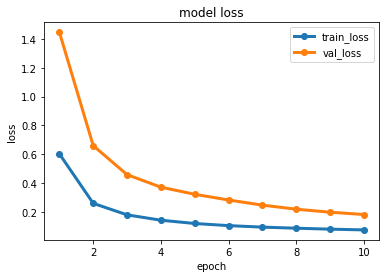

In [22]:
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(1, len(s2dc.loss_list)+1), s2dc.loss_list, label="train_loss", marker="o", linewidth=3)
plt.plot(np.arange(1, len(s2dc.loss_list_val)+1), s2dc.loss_list_val, label="val_loss", marker="o", linewidth=3)
plt.legend()
plt.show()

覚書：https://teratail.com/questions/257543

# 【問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。

サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。


1. 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
2. ReLU
3. 最大プーリング
4. 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
5. ReLU
6. 最大プーリング
7. 平滑化
8. 全結合層　出力ノード数120
9. ReLU
10. 全結合層　出力ノード数84
11. ReLU
12. 全結合層　出力ノード数10
13. ソフトマックス関数

In [23]:
class Scratch2dLeNet:
    def __init__(self, lr=10**-2, batch_size=20, activation_func="ReLU", optimizer="AdaGrad", pooling="MaxPool2D", pool_h_w_stride=2,
                            n_pad=1, stride=1, filter_h=5, filter_w=5, n_filter1=6, n_filter2=16, n_node3=120, n_node4=84, n_epoch=1, verbose = False):
        
        self.lr = lr #学習率
        self.batch_size = batch_size #バッチサイズ
        self.activation_func = activation_func #活性化関数の種類
        self.optimizer = optimizer #最適化手法
        self.pooling = pooling #プーリング方法
        self.pool_h = pool_h_w_stride #poolingウィンドウ縦
        self.pool_w = pool_h_w_stride #poolingウィンドウ横
        self.pool_stride = pool_h_w_stride #poolingストライド
        self.n_pad = n_pad #パディング数
        self.stride = stride #ストライド数
        self.filter_h = filter_h #フィルター縦   
        self.filter_w = filter_w #フィルター横
        self.n_filter1 = n_filter1 #1層目フィルター数
        self.n_filter2 = n_filter2 #2層目フィルター数
        self.n_node3 = n_node3 #3層目ノード数
        self.n_node4 = n_node4 #4層目ノード数
        self.n_epoch =n_epoch #エポック数
        self.loss_list = [] #損失を記録するリスト
        self.loss_list_val = [] #損失を記録するリスト(検証データ用)
        self.verbose = verbose
    
    def calc_out_shape(self, n_in_h, n_in_w, filter_h, filter_w, n_pad, stride):
        n_out_h = int((n_in_h + 2*n_pad - filter_h) // stride + 1)
        n_out_w = int((n_in_w + 2*n_pad - filter_w) // stride + 1)
        return n_out_h, n_out_w    
    
    def fit(self, X, y, X_val=None, y_val=None, cnt = 1):
        batch_size, n_in_ch, n_in_h, n_in_w = X.shape
        n_out_h1, n_out_w1 = self.calc_out_shape(n_in_h, n_in_w, self.filter_h, self.filter_w, self.n_pad, self.stride)
        n_out_h1_p, n_out_w1_p = self.calc_out_shape(n_out_h1, n_out_w1, self.pool_h, self.pool_w, 0, self.pool_stride) 
        n_out_h2, n_out_w2 = self.calc_out_shape(n_out_h1_p, n_out_w1_p, self.filter_h, self.filter_w, self.n_pad, self.stride)
        n_out_h2_p, n_out_w2_p = self.calc_out_shape(n_out_h2, n_out_w2, self.pool_h, self.pool_w, 0, self.pool_stride) 
        n_output = y.shape[1]
        if self.optimizer == "SGD":
            optimizer = SGD(self.lr)
        elif self.optimizer == "AdaGrad":
            optimizer = AdaGrad(self.lr)
        if self.activation_func == "Tanh":
            activation = Tanh()
            initializer = XavierInitializer() #Xavierの初期値
        elif self.activation_func == "Sigmoid":
            activation = Sigmoid()
            initializer = XavierInitializer() #Xavierの初期値
        elif self.activation_func == "ReLU":
            activation = ReLU()
            initializer = HeInitializer() #Heの初期値
        if self.pooling == "MaxPool2D":
            pooling = MaxPool2D(self.pool_h, self.pool_w, self.pool_stride, 0, self)
        elif self.pooing == "AveragePool2D":
            pooling = AveragePool2D(self.pool_h, self.pool_w, self.pool_stride, 0, self)
        self.CNN2d1 = CNN2d(n_in_ch, self.n_filter1, self.filter_h, self.filter_w, initializer, optimizer, self)
        self.activation1 = deepcopy(activation)
        self.pooling1 = deepcopy(pooling)
        self.CNN2d2 = CNN2d(self.n_filter1, self.n_filter2, self.filter_h, self.filter_w, initializer, optimizer, self)
        self.activation2 = deepcopy(activation)
        self.pooling2 = deepcopy(pooling)
        self.Flatten = Flatten()
        self.FC3 = FC(n_out_h2_p*n_out_w2_p*self.n_filter2, self.n_node3, initializer, optimizer, self)
        self.activation3 =  ReLU()
        self.FC4 = FC(self.n_node3, self.n_node4, initializer, optimizer, self)
        self.activation4 =  ReLU()
        self.FC5 = FC(self.n_node4, n_output, initializer, optimizer, self)
        self.activation5 = Softmax()
         
        #fitを再帰させて学習データと検証データの両方を学習させる。検証データがあれば先に検証データを学習させる
        if X_val is None:
            get_mini_batch = GetMiniBatch(X, y, self.batch_size) #GetMiniBatchクラスでミニバッチを作成
        else:
            get_mini_batch = GetMiniBatch(X_val, y_val, self.batch_size) #GetMiniBatchクラスでミニバッチを作成
        
        #学習処理
        for i in range(self.n_epoch):
            loss_list = []
            for mini_X_train, mini_y_train in get_mini_batch:
                # このfor文内でミニバッチが使える

                #forwardの処理
                A1 = self.CNN2d1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                Z1_p = self.pooling1.forward(Z1)
                A2 = self.CNN2d2.forward(Z1_p)
                Z2 = self.activation2.forward(A2)
                Z2_p = self.pooling2.forward(Z2)
                Z2_f = self.Flatten.forward(Z2_p)
                A3 = self.FC3.forward(Z2_f)
                Z3 = self.activation3.forward(A3)
                A4 = self.FC4.forward(Z3)
                Z4 = self.activation4.forward(A4)
                A5 = self.FC5.forward(Z4)
                Z5 = self.activation5.forward(A5)
                
                #backwardの処理
                dA5, loss = self.activation5.backward(Z5, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ4 = self.FC5.backward(dA5)
                dA4 = self.activation4.backward(dZ4)
                dZ3 = self.FC4.backward(dA4)
                dA3 = self.activation3.backward(dZ3)
                dZ2 = self.FC3.backward(dA3)
                dZ2_f = self.Flatten.backward(dZ2)
                dZ2_p = self.pooling2.backward(dZ2_f)
                dA2 = self.activation2.backward(dZ2_p)
                dZ1 = self.CNN2d2.backward(dA2)
                dZ1_p = self.pooling1.backward(dZ1)
                dA1 = self.activation1.backward(dZ1_p)
                dZ0 = self.CNN2d1.backward(dA1) # dZ0は使用しない
                
                """
                Loss Curvを描くための処理
                """                
                loss_list.append(loss)

            
            if X_val is None:
                self.loss_list.append(np.mean(loss_list))
                if self.verbose: #verboseをTrueにした際は学習過程などを出力する
                    print(loss_list)
            else:
                self.loss_list_val.append(np.mean(loss_list))
                if self.verbose: #verboseをTrueにした際は学習過程などを出力する
                    print(loss_list_val)
                
        cnt += 1
        if cnt == 3 or X_val is None:
            return
        
        return self.fit(X, y, cnt = cnt) #検証データが入力されている場合は再帰させて学習データを学習させる。

    def predict(self,X):
        A1 = self.CNN2d1.forward(X)
        Z1 = self.activation1.forward(A1)
        Z1_p = self.pooling1.forward(Z1)
        A2 = self.CNN2d2.forward(Z1_p)
        Z2 = self.activation2.forward(A2)
        Z2_p = self.pooling2.forward(Z2)
        Z2_f = self.Flatten.forward(Z2_p)
        A3 = self.FC3.forward(Z2_f)
        Z3 = self.activation3.forward(A3)
        A4 = self.FC4.forward(Z3)
        Z4 = self.activation4.forward(A4)
        A5 = self.FC5.forward(Z4)
        y = self.activation5.forward(A5)

        print(y)
        
        pred = np.argmax(y, axis=1)
        
        return pred

In [24]:
s2dL = Scratch2dLeNet(lr=10**-2, batch_size=20, activation_func="ReLU", optimizer="AdaGrad", pooling="MaxPool2D", pool_h_w_stride=2,
                            n_pad=1, stride=1, filter_h=5, filter_w=5, n_filter1=6, n_filter2=16, n_node3=120, n_node4=84, n_epoch=10, verbose = False)
s2dL.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

In [25]:
#テストデータ
pred = s2dL.predict(X_test)
print("正解率：{:.2f}".format(accuracy_score(y_test, pred)))
# print("混同行列：")
# print(confusion_matrix(y_test, pred))
# print("classification_report：") #評価をまとめて出力するやつ
# print(classification_report(y_test, pred))

[[5.68275584e-11 2.63951363e-10 7.92539028e-10 ... 9.99999930e-01
  1.15593138e-10 1.29352446e-09]
 [2.04108202e-05 1.78590200e-04 9.99800762e-01 ... 2.38494356e-11
  7.55438917e-10 2.02626046e-11]
 [6.80956750e-09 9.99996397e-01 5.44559608e-09 ... 1.04553002e-06
  1.29635861e-09 4.23137018e-07]
 ...
 [1.53522740e-16 2.49817634e-13 5.81802936e-14 ... 1.63232361e-09
  3.97069677e-13 4.80313883e-10]
 [4.51014147e-08 4.56489617e-07 1.34434435e-11 ... 2.96472766e-07
  1.01744050e-04 7.34895084e-08]
 [6.66982186e-07 4.06211276e-09 1.55884689e-09 ... 2.85376028e-10
  1.81167709e-07 1.83119356e-09]]
正解率：0.97


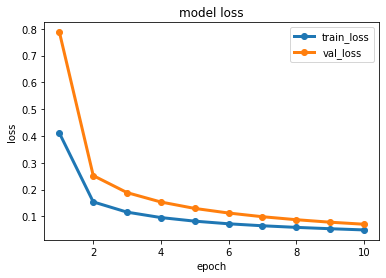

In [26]:
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(1, len(s2dL.loss_list)+1), s2dL.loss_list, label="train_loss", marker="o", linewidth=3)
plt.plot(np.arange(1, len(s2dL.loss_list_val)+1), s2dL.loss_list_val, label="val_loss", marker="o", linewidth=3)
plt.legend()
plt.show()

# 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてはAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。

どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。

- LeNet<br>
1998年に提案された、現Facebook AI ResearchのYann LeCun先生によるCNNの元祖となるネットワーク。畳込み層とプーリング層を交互に重ねたネットワークで、この時点ですでに現在使われているアーキテクチャとほぼ同じ形になっている。活性化関数がシグモイド関数な点、プーリング層がMaxプーリングではなくサブサンプリングで縮小している点などが特徴。

- AlexNet<br>
LeNetが登場してから14年ほど経った2012年に発表された、トロント大のHinton教授を含むチームによるネットワーク。ImageNetを使った画像認識コンペILSVRCで圧倒的な成績を残し、ディープラーニングの火付け役となった。
畳み込み層とプーリング層、そして正規化層と呼ばれる局所的正規化(LRN ― Local Response Normalization)を行う層を重ねた14層のネットワーク。活性化関数はReLUで、Dropoutを用いているのが特徴。他にもData Augmentationなども行っていて、現在使われているCNNでの主要な手法がこの時点ですでに活用されている。
当時はGPU一台にネットワークのすべてのパラメータ(重みなど)を乗せることができなかったので、パラメータを半分にした同一構造のネットワークを2つのGPUに乗せて学習させ、最後に結合していたとか。

- VGG<br>
2014年のILSVRCで2位になった、オックスフォード大学のVGGチームのネットワーク。AlexNetをより深くした、畳み込み層とプーリング層から成るどノーマルなCNNで、重みがある層(畳み込み層や全結合層)を16層、もしくは19層重ねたもの。それぞれVGG16やVGG19と呼ばれる。
小さいフィルターを持つ畳み込み層を2〜4つ連続して重ね、それをプーリング層でサイズを半分にするというのを繰り返し行う構造が特徴。大きいフィルターで画像を一気に畳み込むよりも小さいフィルターを何個も畳み込む(=層を深くする)方が特徴をより良く抽出できる模様。(理由はよくわかってないが、活性化関数を通る回数が増えるため、表現力が増す？)
コンペでは2位に終わったが(1位は後述のGoogLeNet)、とてもシンプルなアーキテクチャなのでよく使われる。

- GoogLeNet<br>
2014年のコンペで1位になったアーキテクチャ。このアーキテクチャは通常の入力層から出力層まで縦一直線な構造ではなく、インセプション構造と呼ばれる横にも層が広がる構造をしている。このため、Inceptionモデルとも呼ばれる。横への層の広がりは、異なるサイズのフィルターの畳み込み層を複数横に並べて、それを結合するという形になっている。

- ResNet<br>
MicrosoftのKaiming He氏による、2015年のILSVRCで優勝したネットワーク。それまでのネットワークでは層を深くしすぎると性能が落ちるという問題があったが、それを「スキップ構造」によって解決し、152層もの深さ(前年優勝のGoogLeNetでも22層)を実現した。
スキップ構造は、ある層への入力をバイパスし層をまたいで奥の層へ入力してしまうというもので、これにより勾配の消失や発散を防止し、超多層のネットワークを実現している。

# 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。


1.
- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

出力サイズ：142×142, 6チャンネル<br>
パラメータ数：3×3×3×6 + 6 = 168<br>


2.
- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

出力サイズ：58×58, 48チャンネル<br>
パラメータ数：24×3×3×48 + 48 = 10416<br>


3.
- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

出力サイズ：9×9, 20チャンネル<br>
パラメータ数：10×3×3×20 + 20 = 1820<br>


＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

# 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。

- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
- 高さや幅方向を持たない1×1のフィルタの効果

#### 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
畳み込み層では画像の特徴抽出を目的とするが、大きいフィルタサイズでは大まかな特徴の抽出しか出来ず、精度が出ないことが考えられる為。

[参考資料](https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363)

#### 高さや幅方向を持たない1×1のフィルタの効果
① 次元削減(=モデルの高速化、軽量化）<br>
② 出力にrelu等を与えることで非線形性UPができる。<br>

解説：<br>
例えば、(縦, 横, チャンネル)=(100, 100, 32)の層を、3×3の畳み込み層を用いて(100,100,64)にすることを考えます。ストレートに畳み込み層を実装すると、必要な変数は32×3×3×64+64=18496個です。次に、この2つの層の間に1×1の畳み込み層を挟んだ場合、1×1畳み込み層の出力チャンネルは32の半分の16とすると、必要な変数は、最初の畳み込み層:32×1×1×16+16=528、次の畳み込み層:16×3×3×64+64=9280、計：9808　となり、層の数は増えているにもかかわらず、元の構造からパラメータの数を半分近くまで落とすことができる。

[参考資料](https://medium.com/lsc-psd/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%82%A8%E3%83%B3%E3%82%B8%E3%83%8B%E3%82%A2%E3%81%AA%E3%82%89%E7%AD%94%E3%81%88%E3%82%89%E3%82%8C%E3%81%A6%E5%BD%93%E7%84%B6%E3%81%AE4%E3%81%A4%E3%81%AE%E5%95%8F%E9%A1%8C-%E7%95%B3%E3%81%BF%E8%BE%BC%E3%81%BF%E5%B1%A4%E7%B7%A8-659809195d2)